In [1]:
!git clone https://github.com/Sanket-DataEnt/groot.git

Cloning into 'groot'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 210 (delta 26), reused 28 (delta 9), pack-reused 162
Receiving objects: 100% (210/210), 461.57 KiB | 16.48 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [2]:
%cd /content/groot/CIFAR

/content/groot/CIFAR


In [4]:
! pip install -U albumentations torch-lr-finder grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [21]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [22]:
import Dataset as ds

trainloader = ds.trainloader
testloader =  ds.testloader

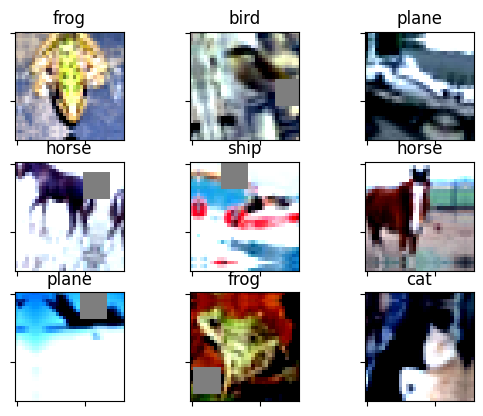

In [23]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

from utils import visualize_images
# Visualizing 10 images
n=9
visualize_images(n, images, labels, classes)

In [24]:
from models import resnet
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.51E-02


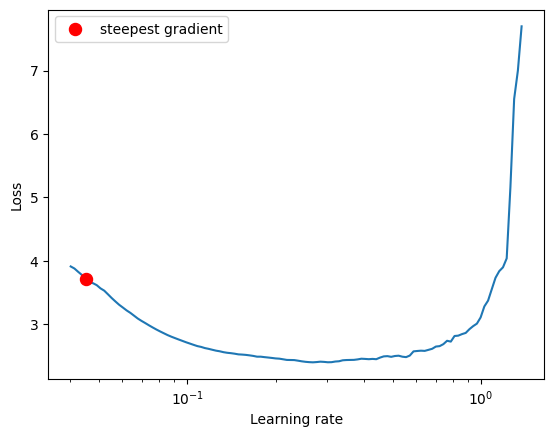

In [25]:
from torch_lr_finder import LRFinder

import torch.optim as optim
import torch.nn as nn

optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader, end_lr=10, num_iter=200, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [26]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 20

scheduler = OneCycleLR(
                      optimizer,
                      max_lr=4.51E-02,
                      steps_per_epoch=len(trainloader),
                      epochs=EPOCHS,
		                  pct_start=5/EPOCHS,
                      div_factor=100,
		                  three_phase=False,
                      final_div_factor=100,
		                  anneal_strategy='linear',
                      )

In [27]:
import torch
from tqdm import tqdm
from utilities.utils import train, test

test_acc = []
train_acc = []
learning_rate = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times
    scheduler.step()
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    train_acc.append(train(model, device, trainloader, optimizer, criterion, epoch))
    test_acc.append(test(model, device, testloader))
    learning_rate.append(param_group['lr'])
print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


lr=  0.00047385005117707267


100%|██████████| 391/391 [01:02<00:00,  6.26it/s]


Epoch= 0 Loss=1.017825961112976 Accuracy=66.25


100%|██████████| 79/79 [00:05<00:00, 13.29it/s]


Accuracy of the network on the 10000 test images: 61.63 %
lr=  0.0004967001023541453


100%|██████████| 391/391 [01:04<00:00,  6.10it/s]


Epoch= 1 Loss=1.028972864151001 Accuracy=60.00


100%|██████████| 79/79 [00:06<00:00, 13.11it/s]


Accuracy of the network on the 10000 test images: 70.12 %
lr=  0.000519550153531218


100%|██████████| 391/391 [01:03<00:00,  6.16it/s]


Epoch= 2 Loss=0.9652996063232422 Accuracy=63.75


100%|██████████| 79/79 [00:06<00:00, 12.03it/s]


Accuracy of the network on the 10000 test images: 75.88 %
lr=  0.0005424002047082907


100%|██████████| 391/391 [01:02<00:00,  6.23it/s]


Epoch= 3 Loss=0.8131743669509888 Accuracy=77.50


100%|██████████| 79/79 [00:06<00:00, 12.02it/s]


Accuracy of the network on the 10000 test images: 79.22 %
lr=  0.0005652502558853634


100%|██████████| 391/391 [01:02<00:00,  6.21it/s]


Epoch= 4 Loss=0.7012343406677246 Accuracy=76.25


100%|██████████| 79/79 [00:06<00:00, 12.08it/s]


Accuracy of the network on the 10000 test images: 79.92 %
lr=  0.0005881003070624361


100%|██████████| 391/391 [01:02<00:00,  6.25it/s]


Epoch= 5 Loss=0.7339791059494019 Accuracy=76.25


100%|██████████| 79/79 [00:06<00:00, 12.02it/s]


Accuracy of the network on the 10000 test images: 81.92 %
lr=  0.0006109503582395087


100%|██████████| 391/391 [01:02<00:00,  6.24it/s]


Epoch= 6 Loss=0.6761923432350159 Accuracy=80.00


100%|██████████| 79/79 [00:06<00:00, 12.10it/s]


Accuracy of the network on the 10000 test images: 82.92 %
lr=  0.0006338004094165814


100%|██████████| 391/391 [01:02<00:00,  6.27it/s]


Epoch= 7 Loss=0.5245879888534546 Accuracy=85.00


100%|██████████| 79/79 [00:06<00:00, 12.21it/s]


Accuracy of the network on the 10000 test images: 83.76 %
lr=  0.0006566504605936541


100%|██████████| 391/391 [01:02<00:00,  6.31it/s]


Epoch= 8 Loss=0.36753982305526733 Accuracy=91.25


100%|██████████| 79/79 [00:06<00:00, 12.23it/s]


Accuracy of the network on the 10000 test images: 84.28 %
lr=  0.0006795005117707267


100%|██████████| 391/391 [01:02<00:00,  6.22it/s]


Epoch= 9 Loss=0.7745439410209656 Accuracy=77.50


100%|██████████| 79/79 [00:06<00:00, 12.07it/s]


Accuracy of the network on the 10000 test images: 84.70 %
lr=  0.0007023505629477994


100%|██████████| 391/391 [01:02<00:00,  6.29it/s]


Epoch= 10 Loss=0.47851476073265076 Accuracy=87.50


100%|██████████| 79/79 [00:06<00:00, 11.74it/s]


Accuracy of the network on the 10000 test images: 84.97 %
lr=  0.0007252006141248721


100%|██████████| 391/391 [01:02<00:00,  6.27it/s]


Epoch= 11 Loss=0.4273163378238678 Accuracy=86.25


100%|██████████| 79/79 [00:06<00:00, 12.25it/s]


Accuracy of the network on the 10000 test images: 85.61 %
lr=  0.0007480506653019447


100%|██████████| 391/391 [01:02<00:00,  6.26it/s]


Epoch= 12 Loss=0.4383470416069031 Accuracy=86.25


100%|██████████| 79/79 [00:06<00:00, 11.96it/s]


Accuracy of the network on the 10000 test images: 87.09 %
lr=  0.0007709007164790174


100%|██████████| 391/391 [01:02<00:00,  6.21it/s]


Epoch= 13 Loss=0.3502269387245178 Accuracy=93.75


100%|██████████| 79/79 [00:06<00:00, 12.39it/s]


Accuracy of the network on the 10000 test images: 87.36 %
lr=  0.0007937507676560901


100%|██████████| 391/391 [01:02<00:00,  6.25it/s]


Epoch= 14 Loss=0.575861394405365 Accuracy=83.75


100%|██████████| 79/79 [00:06<00:00, 11.31it/s]


Accuracy of the network on the 10000 test images: 87.22 %
lr=  0.0008166008188331627


100%|██████████| 391/391 [01:02<00:00,  6.30it/s]


Epoch= 15 Loss=0.32572507858276367 Accuracy=91.25


100%|██████████| 79/79 [00:06<00:00, 12.06it/s]


Accuracy of the network on the 10000 test images: 86.50 %
lr=  0.0008394508700102355


100%|██████████| 391/391 [01:01<00:00,  6.31it/s]


Epoch= 16 Loss=0.4476196765899658 Accuracy=91.25


100%|██████████| 79/79 [00:06<00:00, 12.37it/s]


Accuracy of the network on the 10000 test images: 89.14 %
lr=  0.0008623009211873082


100%|██████████| 391/391 [01:02<00:00,  6.27it/s]


Epoch= 17 Loss=0.6131836175918579 Accuracy=87.50


100%|██████████| 79/79 [00:06<00:00, 12.24it/s]


Accuracy of the network on the 10000 test images: 88.32 %
lr=  0.0008851509723643808


100%|██████████| 391/391 [01:02<00:00,  6.24it/s]


Epoch= 18 Loss=0.2468061000108719 Accuracy=96.25


100%|██████████| 79/79 [00:06<00:00, 12.21it/s]


Accuracy of the network on the 10000 test images: 87.43 %
lr=  0.0009080010235414535


100%|██████████| 391/391 [01:02<00:00,  6.28it/s]


Epoch= 19 Loss=0.3244988024234772 Accuracy=92.50


100%|██████████| 79/79 [00:06<00:00, 11.85it/s]

Accuracy of the network on the 10000 test images: 88.79 %
Finished Training


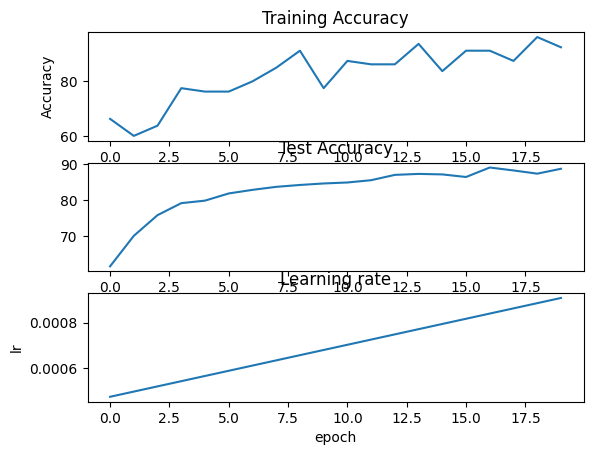

In [28]:
from utilities.utils import plots
plots(train_acc, test_acc, learning_rate)

In [29]:
torch.save(model, 'final_model.pt')

In [30]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = torch.load('final_model.pt').to(device)

## Missclassified Images

  0%|          | 0/79 [00:03<?, ?it/s]


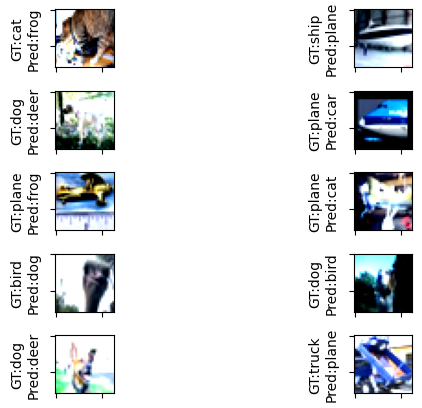

In [33]:
from utilities.utils import show_images, visualize_gradcam

image_tensor, pred, targ = show_images(model, testloader, device, classes, 0)

<Figure size 640x480 with 0 Axes>

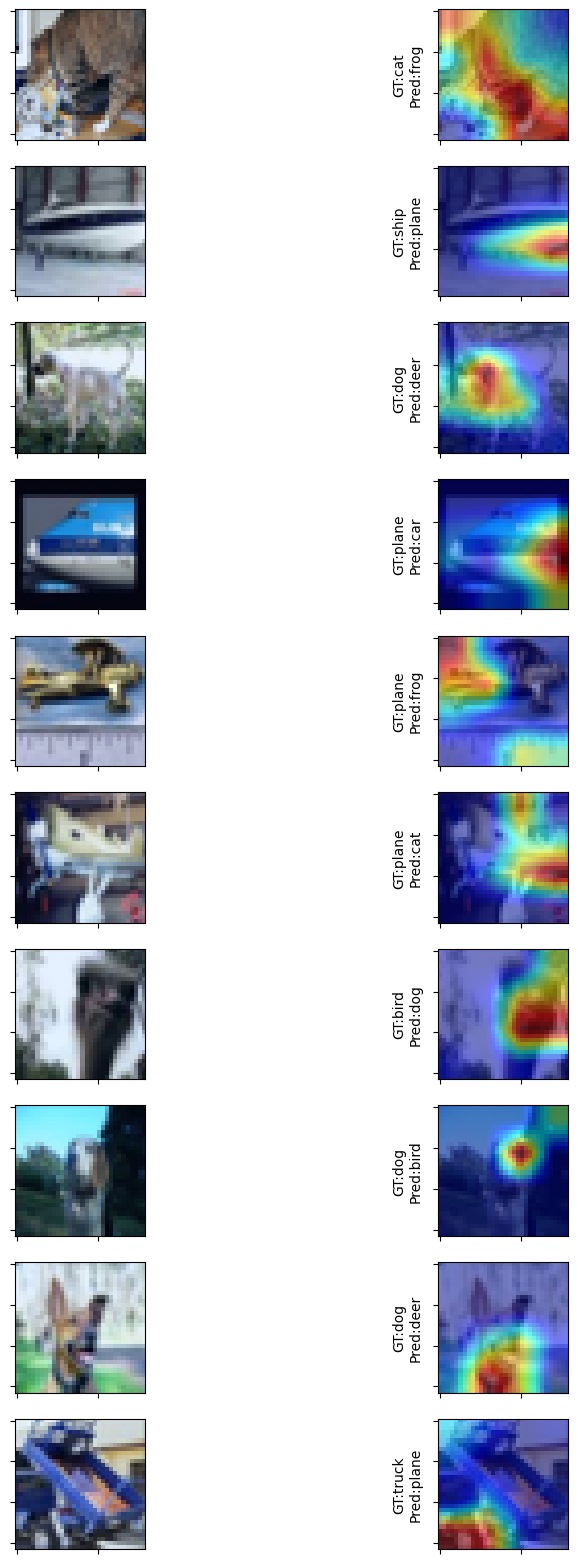

In [34]:
visualize_gradcam(model, image_tensor, targ, pred, classes)

## Correctly classified images


  0%|          | 0/79 [00:03<?, ?it/s]


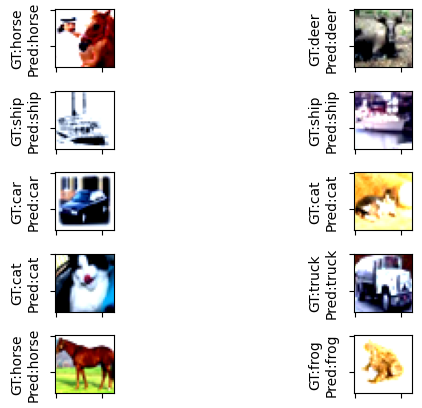

In [35]:
image_tensor, pred, targ = show_images(model, testloader, device, classes, 1)

<Figure size 640x480 with 0 Axes>

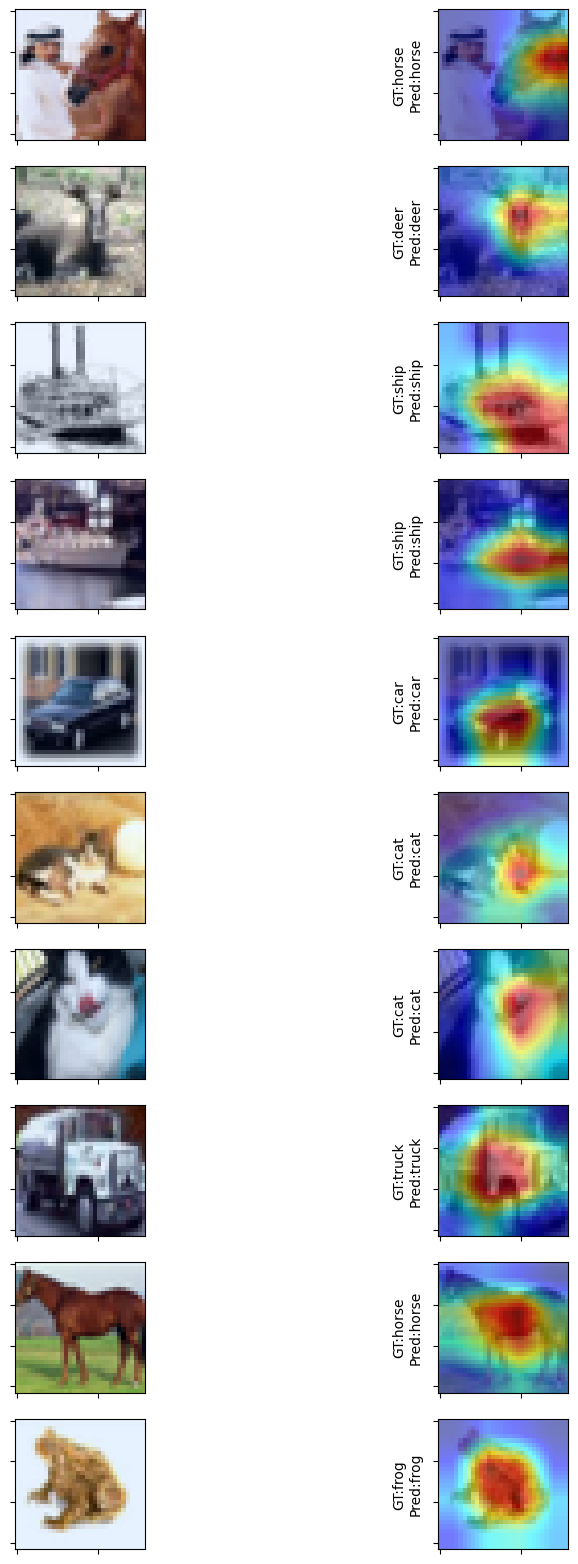

In [36]:
visualize_gradcam(model, image_tensor, targ, pred, classes)
